<a href="https://colab.research.google.com/github/Julian-Oppedisano/MMA-Datathon/blob/main/mma_mart_nltk_with_metrics_graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# load python packages for data processing and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk import pos_tag
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

Exploratory steps

In [2]:
# load the data
from google.colab import files
import pandas as pd

uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

# Load dataset
mma_mart = pd.read_csv('mma_mart.csv')


Saving mma_mart.csv to mma_mart.csv
User uploaded file "mma_mart.csv" with length 67108962 bytes


The dataset has about 987K rows. Since we have about 98K unique orders, on average each order contains about 10 products. We have about 35K unique products, and they are from 134 aisles, and 21 departments.

You perhaps want to do more exploratory data analysis (EDA), but I will move on to pick 1000 products for the special Instabasket aisle.

In [3]:
#average number of aisles per order
aisle_per_order = mma_mart.groupby('order_id')['aisle_id', 'department_id', 'product_name'].nunique().reset_index()

<ipython-input-3-e6b762ba47c7>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  aisle_per_order = mma_mart.groupby('order_id')['aisle_id', 'department_id', 'product_name'].nunique().reset_index()


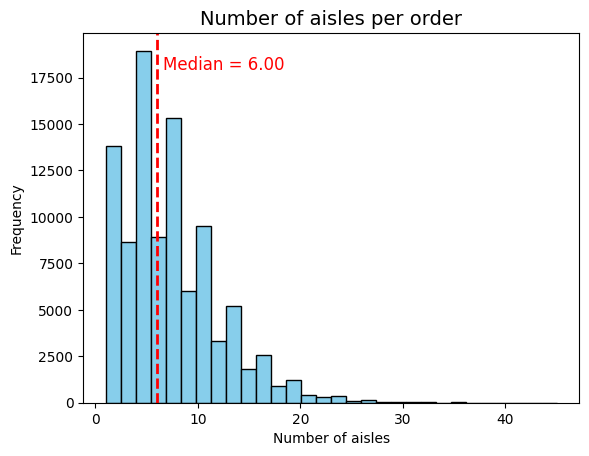

In [4]:
median_aisle = np.median(aisle_per_order['aisle_id'])
plt.hist(aisle_per_order['aisle_id'], bins=30, color='skyblue', edgecolor='black')

plt.axvline(median_aisle, color='red', linestyle='dashed',
                      linewidth=2, label=f'Median = {median_aisle:.2f}')

plt.title('Number of aisles per order', fontsize = 14)
plt.text(median_aisle+6.5, plt.gca().get_ylim()[1]*0.9,
         f'Median = {median_aisle:.2f}', color='red', fontsize=12, ha='center')

# Labeling axes
plt.xlabel('Number of aisles')
plt.ylabel('Frequency')

# Show the histogram
plt.show()

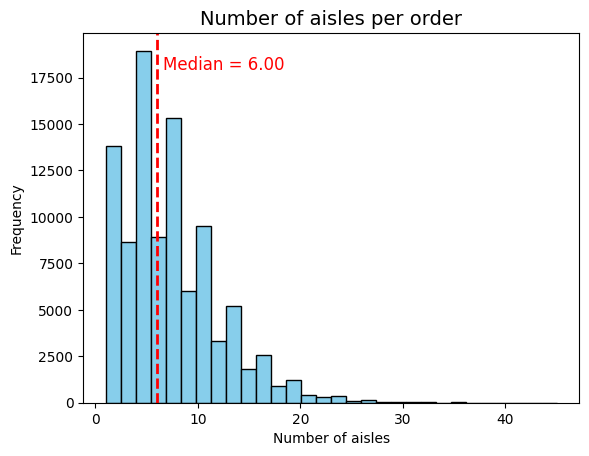

In [5]:
avg_product = np.median(aisle_per_order['product_name'])
plt.hist(aisle_per_order['aisle_id'], bins=30, color='skyblue', edgecolor='black')

plt.axvline(median_aisle, color='red', linestyle='dashed',
                      linewidth=2, label=f'Median = {median_aisle:.2f}')

plt.title('Number of aisles per order', fontsize = 14)
plt.text(median_aisle+6.5, plt.gca().get_ylim()[1]*0.9,
         f'Median = {median_aisle:.2f}', color='red', fontsize=12, ha='center')

# Labeling axes
plt.xlabel('Number of aisles')
plt.ylabel('Frequency')

# Show the histogram
plt.show()

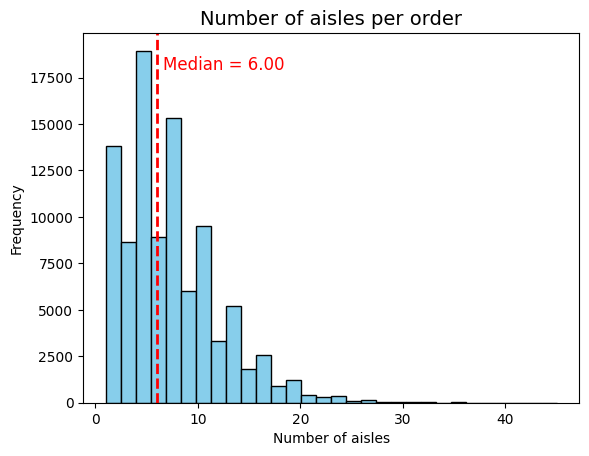

In [6]:
median_aisle = np.median(aisle_per_order['aisle_id'])
plt.hist(aisle_per_order['aisle_id'], bins=30, color='skyblue', edgecolor='black')

plt.axvline(median_aisle, color='red', linestyle='dashed',
                      linewidth=2, label=f'Median = {median_aisle:.2f}')

plt.title('Number of aisles per order', fontsize = 14)
plt.text(median_aisle+6.5, plt.gca().get_ylim()[1]*0.9,
         f'Median = {median_aisle:.2f}', color='red', fontsize=12, ha='center')

# Labeling axes
plt.xlabel('Number of aisles')
plt.ylabel('Frequency')

# Show the histogram
plt.show()

In [7]:
avg_aisle_per_product = np.average(aisle_per_order['aisle_id']/aisle_per_order['product_name'])
print('Average number of aisles travel for each product is:', round(avg_aisle_per_product, 2), ';\n')
max_aisle_per_order = np.max(aisle_per_order['aisle_id'])
print('Max number of aisles travel for one order is:', round(max_aisle_per_order, 2), ';\n')

Average number of aisles travel for each product is: 0.79 ;

Max number of aisles travel for one order is: 45 ;



In [8]:
mma_mart['aisle'].value_counts().to_csv('mma_aisle.csv')

In [9]:
mma_mart['department'].value_counts()

produce            288775
dairy eggs         164468
snacks              88093
beverages           81923
frozen              68202
pantry              56681
bakery              35806
canned goods        32486
deli                32008
dry goods pasta     26096
household           22445
meat seafood        21588
breakfast           21585
personal care       13773
babies              12872
international        8248
alcohol              4580
pets                 3157
missing              2289
other                1097
bulk                 1087
Name: department, dtype: int64

In [10]:
# add tokens into df
#remove non-aplphabets (here I remove numbers as well but it is debatable
mma_mart_plus = mma_mart.drop_duplicates(subset = 'product_id').reset_index()
product = mma_mart_plus['product_name']
product_tokens = [x.split(' ') for x in product]

mma_mart_plus['product_tokens'] = product_tokens

In [ ]:
# Flatten the list of lists
flat_data = [word for sublist in mma_mart_plus['product_tokens'] for word in sublist]

# Use Counter to count word occurrences
word_counts = Counter(flat_data)

# Find the most common word
most_common_words = word_counts.most_common(10)

# Print the most frequent word and its frequency
for word, frequency in most_common_words:
    print(f'{word}: {frequency}')

In [ ]:
# remove stop words
nltk.download('stopwords')  # Download the stopwords data

from nltk.corpus import stopwords

# Get the English stopwords from NLTK
stop_words = set(stopwords.words('english', 'french'))

# Remove stopwords from the list
filtered_word_list = {word: count for word, count in word_counts.items() if word not in stop_words}

# Find the most common word
filtered_most_common_words = Counter(filtered_word_list).most_common(10)

# Print the most frequent word and its frequency
for word, frequency in filtered_most_common_words:
    print(f'{word}: {frequency}')

In [ ]:
# remove words that are not noun
nltk.download('averaged_perceptron_tagger')  # Download the POS tagger data

def is_noun(word):
    pos_tags = pos_tag([word])
    return any(tag.startswith('N') for word, tag in pos_tags)

nouns_dict = {word: count for word, count in filtered_word_list.items() if is_noun(word)}

In [14]:
cleaned_word_list = []

for key in nouns_dict:
    cleaned_word_list.append(key)

In [15]:
import inflect
import re

def alphabet(word):
    output = re.sub(r'[^a-zA-Z]', '', word)
    return (output)

# Create a new DataFrame with specified words removed
filtered_product = mma_mart_plus['product_tokens'].apply(
    lambda words: [alphabet(word) for word in words
                   if ((word in cleaned_word_list) and
                       (len(word) >= 2))])

# Display the filtered DataFrame
print(filtered_product)

0                                  [Yogurt]
1        [Milk, Fat, Milk, Cottage, Cheese]
2                          [Celery, Hearts]
3                         [Cucumber, Kirby]
4                           [Sardines, Oil]
                        ...                
35065                       [Cocoa, Spread]
35066         [Small, Batch, Year, Bourbon]
35067                 [Colby, Jack, Cheese]
35068                    [Peppermint, Bark]
35069                   [Trinity, Capsules]
Name: product_tokens, Length: 35070, dtype: object


In [16]:
import inflect

# Initialize the inflect engine
p = inflect.engine()

# List of words with potential plurals
singular_product = [0]*len(filtered_product)

# Function to convert plural form to singular form
def plural_to_singular(word):
    if len(word) >= 2:
        singular = p.singular_noun(word)
    else: singular = False
    return singular if singular else word  # If singular form not found, return the original word

# Identify and convert plural forms to singular forms
for i in range(0, len(filtered_product)):
    current_word_list = filtered_product[i]
    singular_words = [plural_to_singular(word) for word in current_word_list]
    singular_product[i] = singular_words

In [17]:
mma_mart_plus['token_for_use'] = singular_product

In [18]:
product_name_for_use = [' '.join(x) for x in singular_product]

In [19]:
mma_mart_plus['product_name_for_use'] = product_name_for_use

In [20]:
mma_mart_plus.to_csv('mma_mart(with tokens).csv')

## Jaccard similarity
<br>
Here I assume that substitutes can only be obtained from the same department

In [21]:
df = mma_mart_plus

In [22]:
# Function to calculate Jaccard similarity between two sets
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0


In [82]:
def find_substitute(target_product_id):
    target_product = pd.DataFrame(df[df['product_id'] == target_product_id].reset_index())
    target_department = target_product['department_id'][0]
    department_product = df[df['department_id'] == target_department].reset_index()
    list1 = target_product['token_for_use'][0]
    similarities = [0]*len(department_product)

    for i in range(0, len(department_product)):
        list2 = department_product['token_for_use'][i]
        similarity = jaccard_similarity(set(list1), set(list2))
        similarities[i] = similarity

    output = pd.DataFrame(department_product)
    output['similarity'] = similarities
    if (len(list1) <= 2):
        output = output[(output['similarity'] >= 0.5)]
    elif (len(list1) == 3):
        output = output[(output['similarity'] >= 0.65)]
    else:
        output = output[(output['similarity'] >= 0.75)]

    median_similarity = output['similarity'].median() # Calculate mendian value of all the similarity scores stored in 'similarity' column
    output = output[(output['similarity'] >= median_similarity)] # Only include rows that have a similarity score greater than or equal to the median similarity
    output = output.sort_values(by='similarity', ascending=False).head(5)  # Only show top 5 substitutes


    return(output)



In [83]:
sub11109 = find_substitute(11109)
sub11109

,level_0,index,order_id,product_id,product_name,aisle_id,aisle,department_id,department,product_tokens,token_for_use,product_name_for_use,similarity
1,1,1,1,11109,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,other creams cheeses,16,dairy eggs,"[Organic, 4%, Milk, Fat, Whole, Milk, Cottage,...","[Milk, Fat, Milk, Cottage, Cheese]",Milk Fat Milk Cottage Cheese,1.00
158,923,1171,120,1503,Low Fat Cottage Cheese,108,other creams cheeses,16,dairy eggs,"[Low, Fat, Cottage, Cheese]","[Fat, Cottage, Cheese]",Fat Cottage Cheese,0.75
334,2120,3319,338,11689,On the Go Low Fat Cottage Cheese,108,other creams cheeses,16,dairy eggs,"[On, the, Go, Low, Fat, Cottage, Cheese]","[Fat, Cottage, Cheese]",Fat Cottage Cheese,0.75
450,3121,5757,585,35234,2% Low Fat Cottage Cheese,108,other creams cheeses,16,dairy eggs,"[2%, Low, Fat, Cottage, Cheese]","[Fat, Cottage, Cheese]",Fat Cottage Cheese,0.75
467,3209,6009,608,42307,Organic Reduced Fat 2% Cottage Cheese,108,other creams cheeses,16,dairy eggs,"[Organic, Reduced, Fat, 2%, Cottage, Cheese]","[Fat, Cottage, Cheese]",Fat Cottage Cheese,0.75


Select product

In [64]:
frozen_products = ['frozen']
refrigerated_products = ['dairy eggs', 'meat seafood', 'deli']

In [65]:
def product_label(department):
  if department in frozen_products:
      return 'frozen'
  elif department in refrigerated_products:
      return 'refrigerated'
  else:
    return 'other'


# Apply the labels to each product
mma_mart['product_category'] = mma_mart['department'].apply(product_label)

In [66]:
# Count and sort each product along with its new label
product_frequency_with_category = mma_mart.groupby(['product_id', 'product_category', 'product_name', 'department']).size().reset_index(name='frequency')

product_frequency_with_category_sorted = product_frequency_with_category.sort_values(by='frequency', ascending=False)

# Display top 20 results
product_frequency_with_category_sorted.head(20)

,product_id,product_category,product_name,department,frequency
17569,24852,other,Banana,produce,14494
9234,13176,other,Bag of Organic Bananas,produce,11694
14895,21137,other,Organic Strawberries,produce,8081
15455,21903,other,Organic Baby Spinach,produce,7369
33331,47209,other,Organic Hass Avocado,produce,6411
33723,47766,other,Organic Avocado,produce,5313
33625,47626,other,Large Lemon,produce,4688
11828,16797,other,Strawberries,produce,4340
18524,26209,other,Limes,produce,4225
19774,27966,other,Organic Raspberries,produce,4164


In [67]:
top_1000 = product_frequency_with_category_sorted.head(1000)
top_1000_product_ids = top_1000['product_id'].reset_index()

In [68]:
top_1000_product_ids

,index,product_id
0,17569,24852
1,9234,13176
2,14895,21137
3,15455,21903
4,33331,47209
...,...,...
995,8737,12481
996,18174,25705
997,33951,48094
998,26170,37053


In [69]:
substitute_list = []
for product in top_1000_product_ids['product_id']:
    valid_substitutes = find_substitute(product)
    substitute_list.extend(valid_substitutes['product_id'].tolist())

In [31]:
extended_top_products = list(set(top_1000_product_ids['product_id']).union(set(substitute_list)))

In [ ]:
len(extended_top_products)

Calculate top products

In [62]:
total_orders = mma_mart['order_id'].nunique()
items_per_order = mma_mart.groupby('order_id')['product_id'].count()
average_items_per_order = np.average(items_per_order)

In [63]:
count_orders_with_extended_top_products = mma_mart[mma_mart['product_id'].isin(extended_top_products)]['order_id'].nunique()
percentage_orders_with_extended_top_products = (count_orders_with_extended_top_products / total_orders) * 100
print(f"Percentage of orders with at least one item from extended top products: {percentage_orders_with_extended_top_products:.2f}%")

# Metric 2
total_extended_top_products_in_orders = mma_mart[mma_mart['product_id'].isin(extended_top_products)]['product_id'].count()
average_extended_top_products_per_order = total_extended_top_products_in_orders / total_orders
percentage_extended_top_products_per_order = (average_extended_top_products_per_order / average_items_per_order) * 100

print(f"Average number of extended top products per order: {average_extended_top_products_per_order:.2f}")
print(f"Percentage of extended top products per order: {percentage_extended_top_products_per_order:.2f}%")

Percentage of orders with at least one item from extended top products: 94.26%
Average number of extended top products per order: 6.02
Percentage of extended top products per order: 59.63%


Trips made by shoppers

In [ ]:
new_aisle = [0]*len(mma_mart)
product = mma_mart['product_id']
top_100_product = top_1000_product_ids['product_id']
original_aisle = mma_mart['aisle']

for i in range(0, len(mma_mart)):
  if product[i] in extended_top_products:
      new_aisle[i] =  'aisle'
  else:
    new_aisle[i] = original_aisle[i]


# Apply the labels to each product
mma_mart['new_aisle'] = new_aisle

In [60]:
#average number of aisles per order
new_aisle_per_order = mma_mart.groupby('order_id')['new_aisle'].nunique().reset_index()
np.average(new_aisle_per_order['new_aisle'])

4.3216501589443235

In [75]:
median_new_aisle = np.median(new_aisle_per_order['new_aisle'])
plt.hist(aisle_per_order['new_aisle'], bins=30, color='skyblue', edgecolor='black')

plt.axvline(median_new_aisle, color='red', linestyle='dashed',
                      linewidth=2, label=f'Median = {median_new_aisle:.2f}')

plt.title('Number of aisles per order', fontsize = 14)
plt.text(median_new_aisle+6.5, plt.gca().get_ylim()[1]*0.9,
         f'Median = {median_new_aisle:.2f}', color='red', fontsize=12, ha='center')

# Labeling axes
plt.xlabel('Number of aisles')
plt.ylabel('Frequency')

# Show the histogram
plt.show()

KeyError: ignored

## Precision@K

In [38]:
from sklearn.model_selection import train_test_split


unique_orders = df['order_id'].unique()
train_orders, test_orders = train_test_split(unique_orders, test_size=0.2)

train_data = df[df['order_id'].isin(train_orders)]
test_data = df[df['order_id'].isin(test_orders)]


In [39]:
hits = 0
total_recommended = 0

# Loop each unique product in test set
for actual_product_id in test_data['product_id'].unique():

    #use find_substitute function to find substitutes for this product
    recommended_subs_df = find_substitute(actual_product_id)
    recommended_subs = recommended_subs_df['product_id'].tolist()

    #Count the number of recommended substitutes
    total_recommended += len(recommended_subs)

    orders_with_product = test_data[test_data['product_id'] == actual_product_id]['order_id'].unique()

    # Check if these recommended substitutes appear in the same orders as the actual product
    for order_id in orders_with_product:
        actual_order_products = test_data[test_data['order_id'] == order_id]['product_id'].tolist()
        hits += sum(1 for sub in recommended_subs if sub in actual_order_products)

# Cal Precision@K
if total_recommended > 0:
    precision_at_k = (hits / total_recommended) * 100
else:
    precision_at_k = 0

print("Precision@K:", precision_at_k)


Precision@K: 38.043539090044206


## Charts

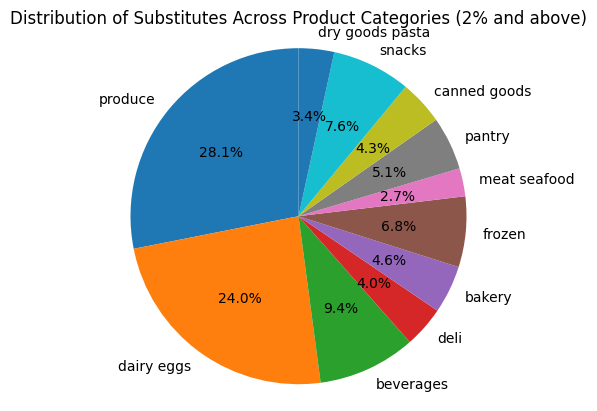

In [48]:
import matplotlib.pyplot as plt

# Initialize dictionary to collect the number of substitutes per category
category_substitute_count = {}

# Loop through the top 1000 product IDs to find valid substitutes
for product in top_1000_product_ids['product_id']:
    valid_substitutes = find_substitute(product)
    for _, row in valid_substitutes.iterrows():
        category = row['department']
        category_substitute_count[category] = category_substitute_count.get(category, 0) + 1

total_substitutes = sum(category_substitute_count.values())

# Filter out categories that contribute less than 2%
filtered_category_substitute_count = {k: v for k, v in category_substitute_count.items() if (v / total_substitutes * 100) >= 2}

# Prepare data
labels = list(filtered_category_substitute_count.keys())
sizes = list(filtered_category_substitute_count.values())

# Create chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Substitutes Across Product Categories (2% and above)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()



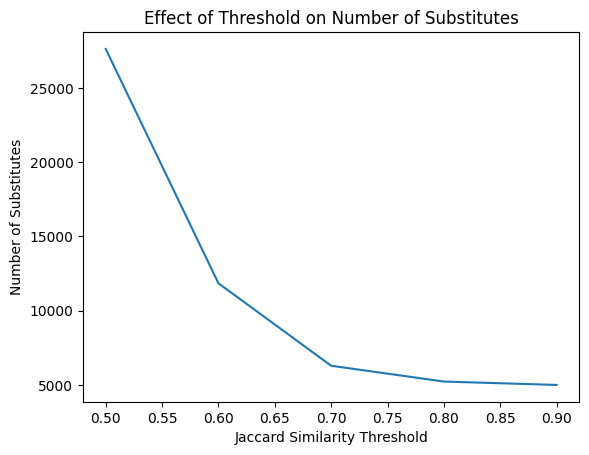

In [53]:
import matplotlib.pyplot as plt


def find_substitute(target_product_id, thresh=0.75):
    target_product = pd.DataFrame(df[df['product_id'] == target_product_id].reset_index())
    target_department = target_product['department_id'][0]
    department_product = df[df['department_id'] == target_department].reset_index()
    list1 = target_product['token_for_use'][0]
    similarities = [0]*len(department_product)

    for i in range(0, len(department_product)):
        list2 = department_product['token_for_use'][i]
        similarity = jaccard_similarity(set(list1), set(list2))
        similarities[i] = similarity

    output = pd.DataFrame(department_product)
    output['similarity'] = similarities

    output = output[(output['similarity'] >= thresh)]

    return(output)


# Listing diff. Jaccard similarity thresh. to explore
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

num_substitutes = []

# Loop through each threshold
for thresh in thresholds:
    count = 0  # Initialize a counter for the number of substitutes
    for product in top_1000_product_ids['product_id']:
        # Call the modified find_substitute function with the threshold as an argument
        valid_substitutes = find_substitute(product, thresh)
        count += len(valid_substitutes)  # Add the number of substitutes found to the counter
    num_substitutes.append(count)  # Append the total count to the list

# Plot
plt.plot(thresholds, num_substitutes)
plt.xlabel('Jaccard Similarity Threshold')
plt.ylabel('Number of Substitutes')
plt.title('Effect of Threshold on Number of Substitutes')
plt.show()


